In [87]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
import torch

from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit,train_epoch
import numpy as np
cuda = torch.cuda.is_available()

In [89]:
data_set = pd.read_csv('./data/Friedman_data.csv')
data_set.columns

Index(['x0', 'x1', 'x2', 'x3', 'x4', 'y'], dtype='object')

In [90]:
# data_set = pd.read_csv('./data/friedman_data.csv')


# drop_columns = ['E_regression', 'E_regression_shift', 'group',
#                'Material compositions 2', 'Material compositions 1']
drop_columns = ['y']
data_set = data_set.drop(drop_columns, axis = 1)

In [91]:
data_set

,x0,x1,x2,x3,x4
0,0.231159,0.181261,0.562884,0.026038,0.839248
1,0.199162,0.826159,0.164871,0.912045,0.922925
2,0.467853,0.639066,0.658997,0.210472,0.112357
3,0.998457,0.282674,0.264726,0.592353,0.049066
4,0.856326,0.464646,0.392572,0.180218,0.885110
...,...,...,...,...,...
995,0.911257,0.619788,0.177249,0.971716,0.114202
996,0.212297,0.587585,0.451137,0.396037,0.527240
997,0.009908,0.511737,0.943483,0.832321,0.460051
998,0.160252,0.546551,0.154820,0.977422,0.562590


### Test loader

In [92]:
# Set up data loaders
from datasets import TripletSampling, BatchPairSampling

In [93]:
data_set_shuffled = data_set.sample(frac=1).reset_index(drop=True)
data_set_shuffled.head()

,x0,x1,x2,x3,x4
0,0.968721,0.264659,0.881764,0.052606,0.847637
1,0.815966,0.306176,0.190583,0.442787,0.649127
2,0.183075,0.896968,0.903065,0.981102,0.091384
3,0.841408,0.777914,0.584179,0.516236,0.792159
4,0.186728,0.086221,0.047146,0.433559,0.087179


In [94]:
# fake labels for pos/neg
labels = [1]* int(0.5 * data_set_shuffled.shape[0]) + [0]*int( 0.5 * data_set_shuffled.shape[0] ) 

In [95]:
data_set_shuffled.values

array([[0.96872095, 0.26465876, 0.88176358, 0.05260632, 0.84763703],
       [0.81596637, 0.30617573, 0.19058285, 0.44278688, 0.64912719],
       [0.18307481, 0.89696822, 0.90306477, 0.98110191, 0.09138392],
       ...,
       [0.21101031, 0.15217328, 0.6200702 , 0.22680864, 0.64727143],
       [0.20737245, 0.07190747, 0.52721822, 0.06758049, 0.15274021],
       [0.43138808, 0.84719305, 0.3678175 , 0.16912399, 0.12010807]])

In [96]:
data_set_shuffled = torch.tensor(data_set_shuffled.values)

In [97]:
datasampler = BatchPairSampling( dataset = data_set_shuffled , labels=labels)
batch_size = 20
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

In [98]:
for batch,_ in train_loader:
    print(batch)
    break

[tensor([[0.7454, 0.8645, 0.2815, 0.3930, 0.0818],
        [0.5531, 0.7472, 0.8562, 0.3397, 0.6506],
        [0.7997, 0.2510, 0.1514, 0.8719, 0.7645],
        [0.2820, 0.9100, 0.5834, 0.1050, 0.0122],
        [0.2837, 0.8859, 0.9708, 0.7222, 0.4153],
        [0.9650, 0.6193, 0.3739, 0.0841, 0.0692],
        [0.3524, 0.6243, 0.5143, 0.3788, 0.8641],
        [0.5663, 0.8380, 0.7281, 0.1647, 0.0578],
        [0.5276, 0.3980, 0.1608, 0.9052, 0.1428],
        [0.2623, 0.2086, 0.8179, 0.4551, 0.1012],
        [0.9589, 0.2829, 0.1450, 0.5976, 0.8450],
        [0.6814, 0.8743, 0.8132, 0.6882, 0.7904],
        [0.6669, 0.1849, 0.7153, 0.6134, 0.1438],
        [0.1964, 0.1237, 0.5845, 0.5967, 0.0210],
        [0.4857, 0.1409, 0.5371, 0.1463, 0.1524],
        [0.4436, 0.5577, 0.9898, 0.0992, 0.1828],
        [0.0556, 0.3046, 0.5073, 0.0224, 0.0361],
        [0.2262, 0.1493, 0.2696, 0.5478, 0.9795],
        [0.2145, 0.4590, 0.1345, 0.3905, 0.2128],
        [0.6777, 0.1522, 0.5702, 0.6564, 0.6780]]

### Test model

In [99]:
from networks import EmbeddingNet, TripletNet, SiameseNet

In [100]:
input_size = data_set_shuffled.shape[1]
hidden_size = 100
embedding_size = 10
net = EmbeddingNet(input_size, hidden_size, embedding_size)
# triplet_net = TripletNet(  embedding_net = net )
siamese_net = SiameseNet(  embedding_net = net )

In [101]:
x1 = torch.rand( 1,5)
x2 = torch.rand( 1,5)

emb1, emb2= siamese_net(x1,x2)

In [102]:
emb1

tensor([[ 0.0456,  0.0416,  0.0495,  0.1147, -0.1261,  0.0078,  0.0849,  0.0420,
         -0.0303,  0.0300]], grad_fn=<AddmmBackward>)

### Test loss

In [103]:
from losses import TripletLoss, HardNegativesBatchLoss

def euclidean(a,b):
    if len(a.shape) == 1:
        a = torch.unsqueeze(a,0)
        b = torch.unsqueeze(b,0)
#     print(a)
#     print(b)
    return (a - b).pow(2).sum(1)

margin = 1
distance = euclidean
# loss_fn = TripletLoss( margin = margin, distance = distance)
loss_fn = HardNegativesBatchLoss( margin = margin, distance = distance)

In [104]:
loss_fn(*batch)

tensor(0.9462, dtype=torch.float64)

### Test training

In [105]:
loss_fn = HardNegativesBatchLoss( margin = margin, distance = distance)
lr = 1e-3

hidden_size = 20
embedding_size = 5
net = EmbeddingNet(input_size, hidden_size, embedding_size)
# triplet_net = TripletNet(  embedding_net = net )
siamese_net = SiameseNet(  embedding_net = net )


model = siamese_net
model = model.float() 
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 100

datasampler = BatchPairSampling( dataset = data_set_shuffled , labels=labels)
batch_size = 5
train_loader = torch.utils.data.DataLoader(datasampler, batch_size=batch_size, shuffle=True)

interval = 20

In [106]:
%%time
fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, interval)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/1000 (0%)]	Loss: 0.999206
Train: [100/1000 (10%)]	Loss: 0.999122
Train: [200/1000 (20%)]	Loss: 0.997197
Train: [300/1000 (30%)]	Loss: 0.997580
Train: [400/1000 (40%)]	Loss: 0.986207
Train: [500/1000 (50%)]	Loss: 0.945887
Train: [600/1000 (60%)]	Loss: 0.876967
Train: [700/1000 (70%)]	Loss: 0.815527
Train: [800/1000 (80%)]	Loss: 0.728293
Train: [900/1000 (90%)]	Loss: 0.802950
Epoch: 1/100. Train set: Average loss: 0.8790
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.555198
Train: [200/1000 (20%)]	Loss: 0.572400
Train: [300/1000 (30%)]	Loss: 0.526122
Train: [400/1000 (40%)]	Loss: 0.530180
Train: [500/1000 (50%)]	Loss: 0.453043
Train: [600/1000 (60%)]	Loss: 0.493441
Train: [700/1000 (70%)]	Loss: 0.605578
Train: [800/1000 (80%)]	Loss: 0.589309
Train: [900/1000 (90%)]	Loss: 0.628450
Epoch: 2/100. Train set: Average loss: 0.5737
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.603435
Train: [200/1000 (20%)]	Loss: 0.527243
Train: [300/1000 (30

Train: [200/1000 (20%)]	Loss: 0.354434
Train: [300/1000 (30%)]	Loss: 0.266314
Train: [400/1000 (40%)]	Loss: 0.530553
Train: [500/1000 (50%)]	Loss: 0.530401
Train: [600/1000 (60%)]	Loss: 0.488681
Train: [700/1000 (70%)]	Loss: 0.433029
Train: [800/1000 (80%)]	Loss: 0.397255
Train: [900/1000 (90%)]	Loss: 0.686498
Epoch: 20/100. Train set: Average loss: 0.4755
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.199960
Train: [200/1000 (20%)]	Loss: 0.328444
Train: [300/1000 (30%)]	Loss: 0.505823
Train: [400/1000 (40%)]	Loss: 0.303665
Train: [500/1000 (50%)]	Loss: 0.414769
Train: [600/1000 (60%)]	Loss: 0.609733
Train: [700/1000 (70%)]	Loss: 0.405579
Train: [800/1000 (80%)]	Loss: 0.319427
Train: [900/1000 (90%)]	Loss: 0.553508
Epoch: 21/100. Train set: Average loss: 0.4220
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.323108
Train: [200/1000 (20%)]	Loss: 0.667995
Train: [300/1000 (30%)]	Loss: 0.170703
Train: [400/1000 (40%)]	Loss: 0.661086
Train: [500/100

Train: [300/1000 (30%)]	Loss: 0.433303
Train: [400/1000 (40%)]	Loss: 0.583481
Train: [500/1000 (50%)]	Loss: 0.555165
Train: [600/1000 (60%)]	Loss: 0.430978
Train: [700/1000 (70%)]	Loss: 0.460597
Train: [800/1000 (80%)]	Loss: 0.251647
Train: [900/1000 (90%)]	Loss: 0.510323
Epoch: 39/100. Train set: Average loss: 0.5409
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.651149
Train: [200/1000 (20%)]	Loss: 0.249669
Train: [300/1000 (30%)]	Loss: 0.461003
Train: [400/1000 (40%)]	Loss: 0.468061
Train: [500/1000 (50%)]	Loss: 0.528676
Train: [600/1000 (60%)]	Loss: 0.516595
Train: [700/1000 (70%)]	Loss: 0.403947
Train: [800/1000 (80%)]	Loss: 0.512519
Train: [900/1000 (90%)]	Loss: 0.448182
Epoch: 40/100. Train set: Average loss: 0.4688
Train: [0/1000 (0%)]	Loss: 1.225848
Train: [100/1000 (10%)]	Loss: 0.339341
Train: [200/1000 (20%)]	Loss: 0.307208
Train: [300/1000 (30%)]	Loss: 0.568998
Train: [400/1000 (40%)]	Loss: 0.489519
Train: [500/1000 (50%)]	Loss: 0.368092
Train: [600/100

Train: [300/1000 (30%)]	Loss: 0.476303
Train: [400/1000 (40%)]	Loss: 0.441869
Train: [500/1000 (50%)]	Loss: 0.411688
Train: [600/1000 (60%)]	Loss: 0.589395
Train: [700/1000 (70%)]	Loss: 0.716299
Train: [800/1000 (80%)]	Loss: 0.463946
Train: [900/1000 (90%)]	Loss: 0.422046
Epoch: 58/100. Train set: Average loss: 0.4790
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.276258
Train: [200/1000 (20%)]	Loss: 0.653368
Train: [300/1000 (30%)]	Loss: 0.200218
Train: [400/1000 (40%)]	Loss: 0.481461
Train: [500/1000 (50%)]	Loss: 0.394162
Train: [600/1000 (60%)]	Loss: 0.575406
Train: [700/1000 (70%)]	Loss: 0.254525
Train: [800/1000 (80%)]	Loss: 0.567541
Train: [900/1000 (90%)]	Loss: 0.529533
Epoch: 59/100. Train set: Average loss: 0.4451
Train: [0/1000 (0%)]	Loss: 1.292462
Train: [100/1000 (10%)]	Loss: 0.221559
Train: [200/1000 (20%)]	Loss: 0.524206
Train: [300/1000 (30%)]	Loss: 0.802790
Train: [400/1000 (40%)]	Loss: 0.680621
Train: [500/1000 (50%)]	Loss: 0.739476
Train: [600/100

Train: [500/1000 (50%)]	Loss: 0.664221
Train: [600/1000 (60%)]	Loss: 0.590989
Train: [700/1000 (70%)]	Loss: 0.277465
Train: [800/1000 (80%)]	Loss: 0.674805
Train: [900/1000 (90%)]	Loss: 0.420814
Epoch: 77/100. Train set: Average loss: 0.4343
Train: [0/1000 (0%)]	Loss: 0.503491
Train: [100/1000 (10%)]	Loss: 0.391084
Train: [200/1000 (20%)]	Loss: 0.506891
Train: [300/1000 (30%)]	Loss: 0.527118
Train: [400/1000 (40%)]	Loss: 0.677778
Train: [500/1000 (50%)]	Loss: 0.636576
Train: [600/1000 (60%)]	Loss: 0.483018
Train: [700/1000 (70%)]	Loss: 0.189863
Train: [800/1000 (80%)]	Loss: 0.591116
Train: [900/1000 (90%)]	Loss: 0.446527
Epoch: 78/100. Train set: Average loss: 0.4964
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.612831
Train: [200/1000 (20%)]	Loss: 0.346255
Train: [300/1000 (30%)]	Loss: 0.810393
Train: [400/1000 (40%)]	Loss: 0.532734
Train: [500/1000 (50%)]	Loss: 0.362264
Train: [600/1000 (60%)]	Loss: 0.381799
Train: [700/1000 (70%)]	Loss: 0.564805
Train: [800/100

Train: [600/1000 (60%)]	Loss: 0.330662
Train: [700/1000 (70%)]	Loss: 0.743939
Train: [800/1000 (80%)]	Loss: 0.529876
Train: [900/1000 (90%)]	Loss: 0.300276
Epoch: 96/100. Train set: Average loss: 0.5126
Train: [0/1000 (0%)]	Loss: 0.794314
Train: [100/1000 (10%)]	Loss: 0.648406
Train: [200/1000 (20%)]	Loss: 0.371251
Train: [300/1000 (30%)]	Loss: 0.809256
Train: [400/1000 (40%)]	Loss: 0.543600
Train: [500/1000 (50%)]	Loss: 0.614673
Train: [600/1000 (60%)]	Loss: 0.499339
Train: [700/1000 (70%)]	Loss: 0.549352
Train: [800/1000 (80%)]	Loss: 0.386538
Train: [900/1000 (90%)]	Loss: 0.441896
Epoch: 97/100. Train set: Average loss: 0.5201
Train: [0/1000 (0%)]	Loss: 0.000000
Train: [100/1000 (10%)]	Loss: 0.506952
Train: [200/1000 (20%)]	Loss: 0.241558
Train: [300/1000 (30%)]	Loss: 0.699322
Train: [400/1000 (40%)]	Loss: 0.594742
Train: [500/1000 (50%)]	Loss: 0.519284
Train: [600/1000 (60%)]	Loss: 0.646275
Train: [700/1000 (70%)]	Loss: 0.349295
Train: [800/1000 (80%)]	Loss: 0.511419
Train: [900/100

In [107]:
def extract_embeddings(dataset, labels, model):
    with torch.no_grad():
        model.eval()
        embeddings = []

        for data in dataset:

            embeddings.append( 
                np.array( 
                    model.get_embedding(data).detach().numpy() ) )

    return np.array(embeddings), labels

In [108]:
embs,labels = extract_embeddings(data_set_shuffled , labels, model)

In [109]:

from sklearn.manifold import TSNE
# embedded_2 = TSNE(n_components=2, learning_rate='auto',
#      init='random').fit_transform(embs)
tsne = TSNE(n_components=2, perplexity = 5, learning_rate='auto',init='random')
mds = sklearn.manifold.MDS(n_components=2,metric=True, 
                                  n_init=4, 
                                  max_iter=300,
                                  verbose=0, eps=0.001, n_jobs=None, random_state= 1024, dissimilarity='euclidean')


In [110]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    targets = np.array(targets)
    colors = ['r', 'b']
    shapes = ['*', '^']
    for cls in set(targets):
        mask = targets == cls
        cls_emb = embeddings[mask]
        plt.scatter(cls_emb[:,0], cls_emb[:,1], alpha=0.5, marker = shapes[cls],c = colors[cls])

    plt.legend(set(targets))

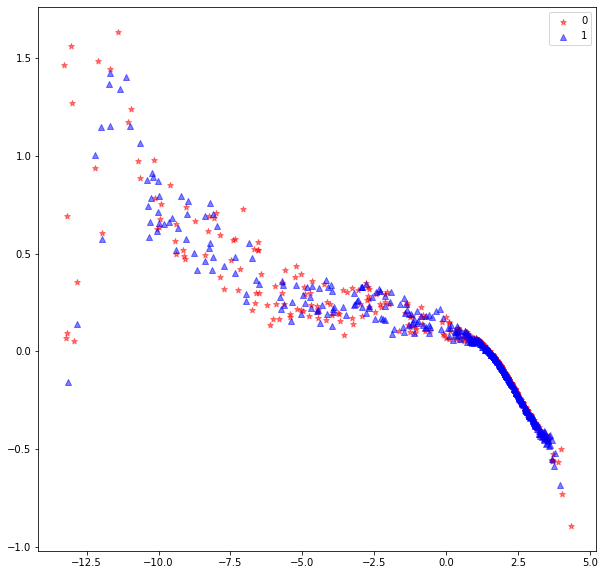

In [111]:
embedded_2 = mds.fit_transform(embs)
plot_embeddings(embedded_2, labels)

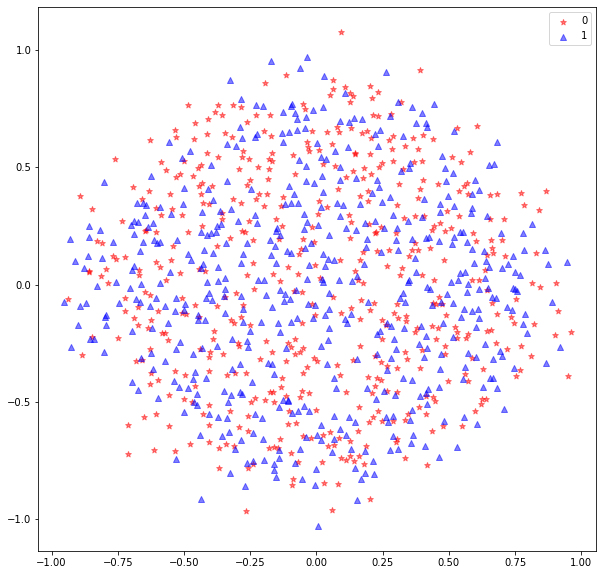

In [112]:
embedded_2_origin = mds.fit_transform(data_set_shuffled)
plot_embeddings(embedded_2_origin, labels)